**Launch this interactive notebook in Binder ⇒** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/arundo/adtk/master?filepath=docs%2Fnotebooks%2Fdemo.ipynb)

## Detector

### ThresholdAD

`ThresholdAD` compares each time series value with given thresholds.

In the following example, we detect time points when temperature is above 30C or below 15C.

In [1]:
import pandas as pd
s = pd.read_csv('./data/temperature.csv', index_col="Time", parse_dates=True, squeeze=True)
from adtk.data import validate_series
s = validate_series(s)

In [2]:
from adtk.detector import ThresholdAD
threshold_ad = ThresholdAD(high=30, low=15)
anomalies = threshold_ad.fit_detect(s)

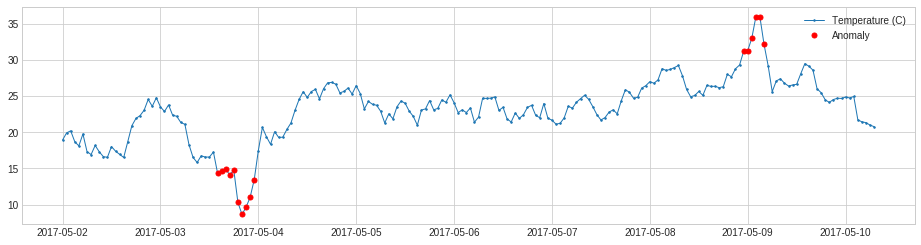

In [3]:
from adtk.visualization import plot
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### QuantileAD

`QuantileAD` compares each time series value with historical quantiles.

In the following example, we detect time points when temperature is above 99% percentile or below 1% percentile.

In [4]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)

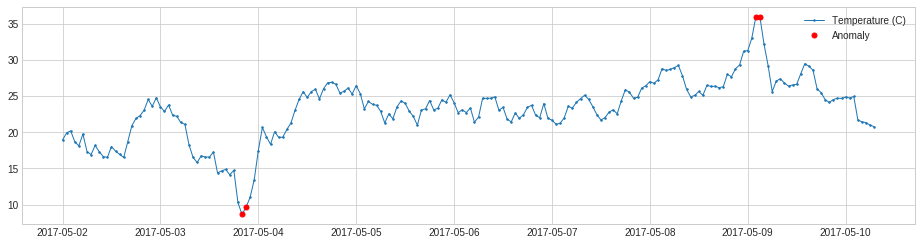

In [5]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### InterQuartileRangeAD

`InterQuartileRangeAD` is another widely used detector based on simple historical statistics is based on interquartile range (IQR). When a value is out of the range defined by $[Q_1 - c \times IQR,\  Q_3 + c \times IQR]$ where $IQR = Q_3 - Q_1$ is the difference between 25% and 75% quantiles. This detector is usually preferred to QuantileAD in the case where only a tiny portion or even none of training data is anomalous.

In [6]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)

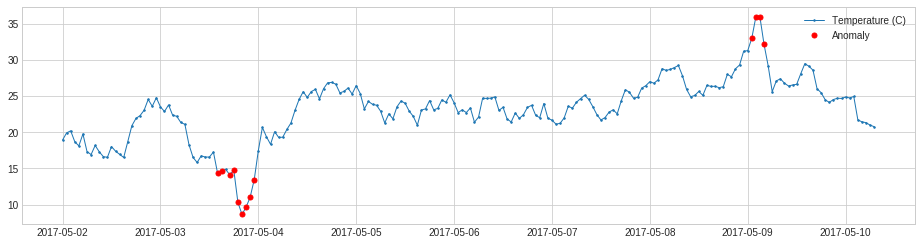

In [7]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### GeneralizedESDTestAD

`GeneralizedESDTestAD` detects anomaly based on generalized extreme Studentized deviate (ESD) test.

Please note a key assumption of generalized ESD test is that normal values follow an approximately normal distribution. Please only use this detector when this assumption holds.

In [8]:
from adtk.detector import GeneralizedESDTestAD
esd_ad = GeneralizedESDTestAD(alpha=0.3)
anomalies = esd_ad.fit_detect(s)

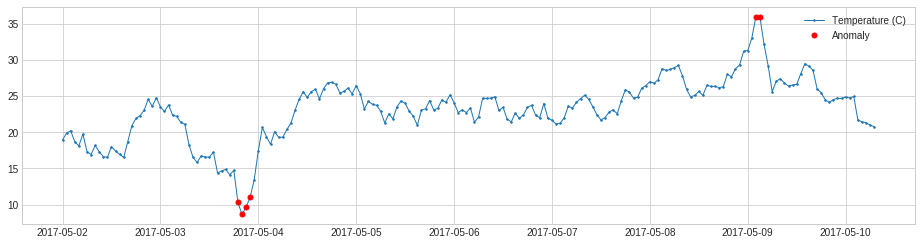

In [9]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### PersistAD

`PersistAD` compares each time series value with its previous values. Internally, it is implemented as a [pipenet](#Pipenet) with transformer [DoubleRollingAggregate](#DoubleRollingAggregate).


In the following example, we detect anomalous positive changes of price.

In [10]:
s = pd.read_csv('./data/price_short.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

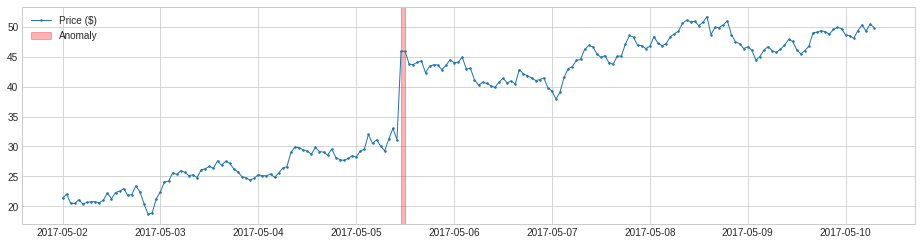

In [11]:
from adtk.detector import PersistAD
persist_ad = PersistAD(c=3.0, side='positive')
anomalies = persist_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red');

By default, `PersistAD` only check one previous value, which is good at capturing additive anomaly in short-term scale, but not in long-term scale because it is too near-sighted. 

In the following example, it fails to capture meaningful drops of price in a longer time scale.

In [12]:
s = pd.read_csv('./data/price_long.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

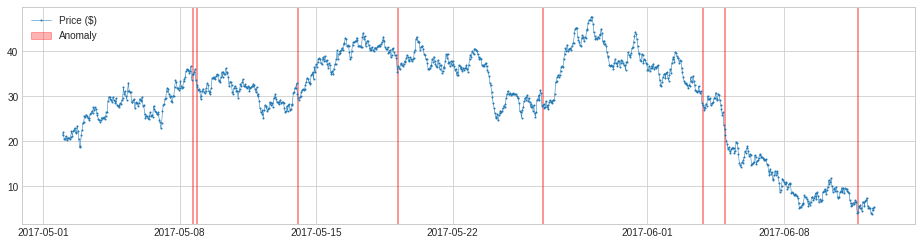

In [13]:
persist_ad = PersistAD(c=1.5, side='negative')
anomalies = persist_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

We may change the parameter `window` to a number greater than 1, and the detector will compare a value to the median or mean of its preceding time window. This will capture anomalous changes in mid- to long-term scale, because it is less near-sighted. In the same example as above, it detects drops of price in the long-term scale successfully.

In [14]:
persist_ad.window = 24
anomalies = persist_ad.fit_detect(s)

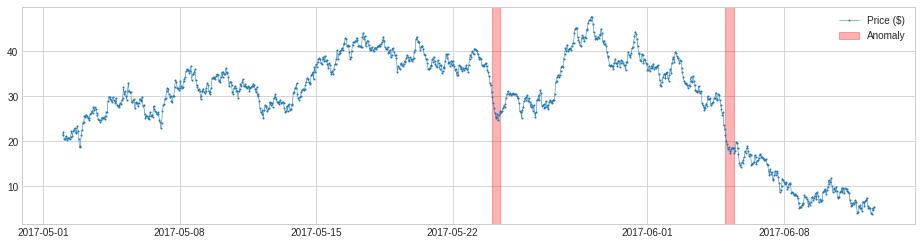

In [15]:
plot(s, anomaly=anomalies, anomaly_color='red');

### LevelShiftAD

`LevelShiftAD` detects shift of value level by tracking the difference between median values at two sliding time windows next to each other. It is not sensitive to instantaneous spikes and could be a good choice if noisy outliers happen frequently. Internally, it is implemented as a [pipenet](#Pipenet) with transformer [DoubleRollingAggregate](#DoubleRollingAggregate).

In the following example, we detect shift point of CPU usage.

In [16]:
s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

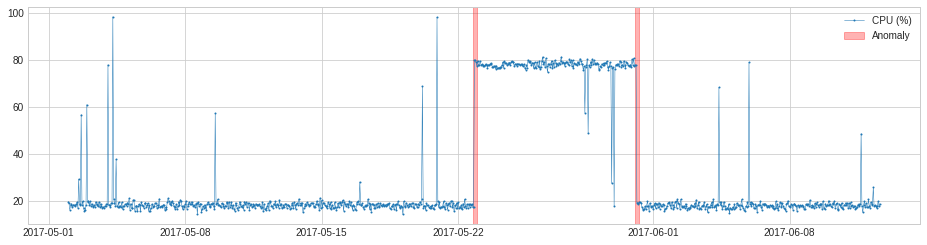

In [17]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=5)
anomalies = level_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

### VolatilityShiftAD

`VolatilityShiftAD` detects shift of volatility level by tracking the difference between standard deviations at two sliding time windows next to each other. Internally, it is implemented as a [pipenet](#Pipenet) with transformer [DoubleRollingAggregate](#DoubleRollingAggregate).

In the following example, we detect positive shift of volatility of seismic amplitude which indicates start of earthquake.

In [18]:
s = pd.read_csv('./data/seismic.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

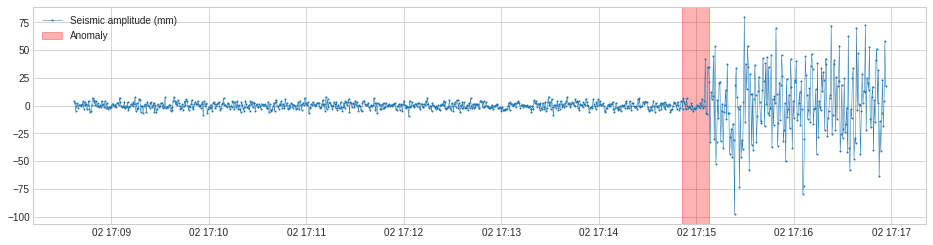

In [19]:
from adtk.detector import VolatilityShiftAD
volatility_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

### SeasonalAD

`SeasonalAD` detects anomalous violations of seasonal pattern. Internally, it is implemented as a [pipenet](#Pipenet) with transformer [ClassicSeasonalDecomposition](#ClassicSeasonalDecomposition).

In the following example, we detect unusual traffic, which mostly happened on major holidays.

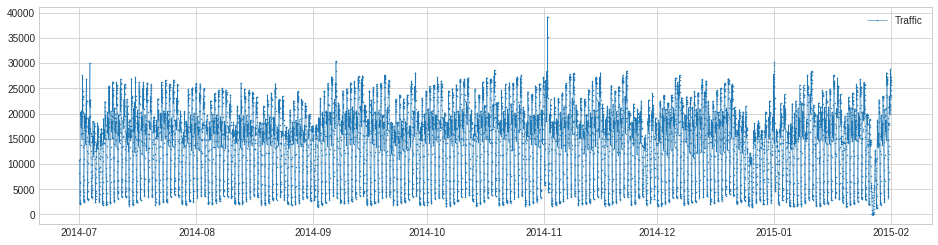

In [20]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)
plot(s, ts_markersize=1);

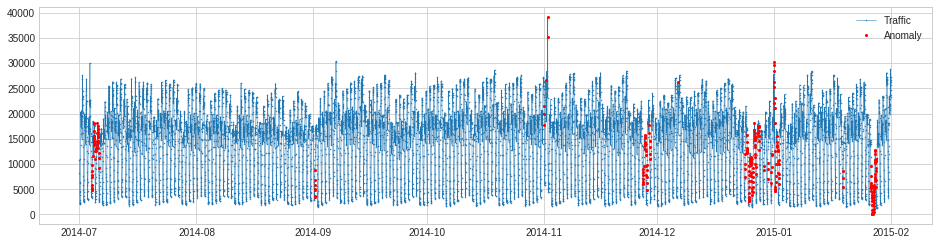

In [21]:
from adtk.detector import SeasonalAD
seasonal_ad = SeasonalAD(c=3.0, side="both")
anomalies = seasonal_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2);

### AutoregressionAD

`AutoregressionAD` detects anomalous changes of autoregressive behavior in time series. Internally, it is implemented as a [pipenet](#Pipenet) with transformers [Retrospect](#Retrospect) and [RegressionResidual](#RegressionResidual).

For the same example as above, we detect violation of usual regressive behavior in traffic history.

In [22]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

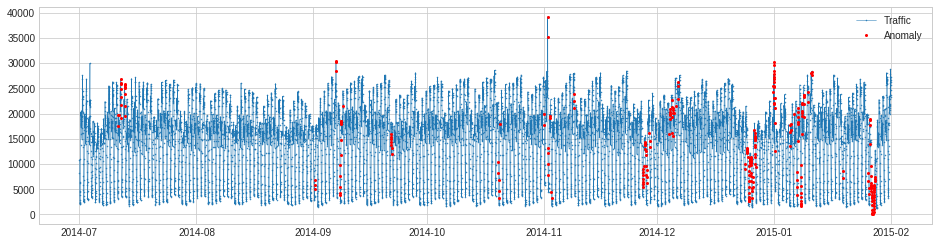

In [23]:
from adtk.detector import AutoregressionAD
autoregression_ad = AutoregressionAD(n_steps=7*2, step_size=24, c=3.0)
anomalies = autoregression_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_color='red', anomaly_tag="marker", anomaly_markersize=2);

### MinClusterDetector

`MinClusterDetector` treats multivariate time series as independent points in a high-dimensional space, divides them into clusters, and identifies values in the smallest cluster as anomalous. This may help capturing outliers in high-dimensional space.

In the following example, we detect anomalous changes of relationship between the speed of a generator and power generated. The violation of regular relationship indicates equipment failure.

In [24]:
df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True, squeeze=True)
df = validate_series(df)

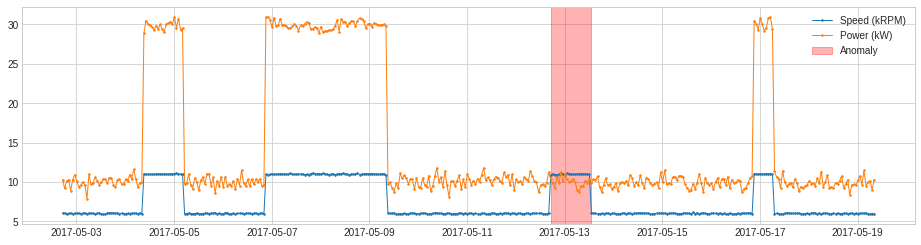

In [25]:
from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### OutlierDetector

`OutlierDetector` performs multivariate time-independent outlier detection and identifies outliers as anomalies. The multivariate outlier detection algorithm could be those in scikit-learn or other packages following same API.

For the same example as above, we apply `OutlierDetector` with a scikit-learn local outlier factor model.

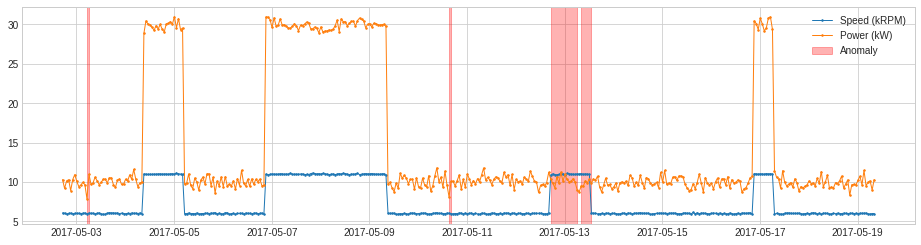

In [26]:
from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### RegressionAD

`RegressionAD` detects anomalous violation of usual relationship between multivariate series by tracking regressive error. Internally, it is implemented as a [pipenet](#Pipenet) with transformer [RegressionResidual](#RegressionResidual).

For the same example as above, we apply `RegressionAD` with linear regression model.

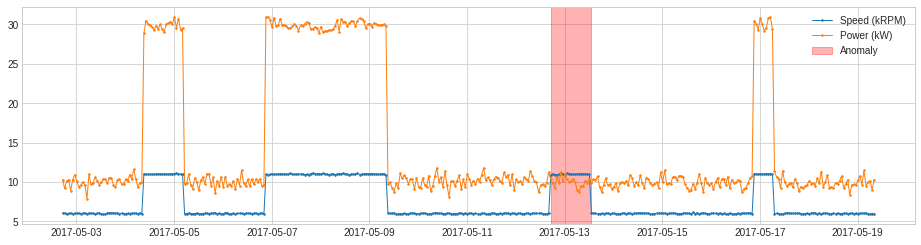

In [27]:
from adtk.detector import RegressionAD
from sklearn.linear_model import LinearRegression
regression_ad = RegressionAD(regressor=LinearRegression(), target="Speed (kRPM)", c=3.0)
anomalies = regression_ad.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### PcaAD

`PcaAD` performs principal component analysis (PCA) to multivariate time series (every time point as a vector in a high-dimensional space) and tracks reconstruction error of those vectors. This detector may be helpful when normal points are supposed to be at a lower-rank manifold while anomalous points are not. Internally, it is implemented as a [pipeline](#Pipeline) with transformer [PcaReconstructionError](#PcaReconstructionError).

We apply `PcaAD` to the same example as above.

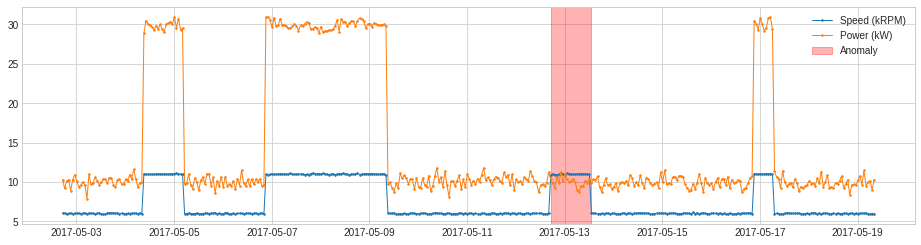

In [28]:
from adtk.detector import PcaAD
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

### CustomizedDetector

`CustomizedDetector1D` and `CustomizedDetectorHD` help a user convert a function into a customized detector object that could be used (by a `Pipeline` object, for example) as other detector object.

In the following example, we detect when the power generated (in kW) is less than 1.2 times generator speed (in kRPM).

In [29]:
df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True)
df = validate_series(df)
df.head()

Speed (kRPM)  Power (kW)
Time                                         
2017-05-02 17:08:37      6.066579   10.308257
2017-05-02 18:08:37      6.035764    9.186763
2017-05-02 19:08:37      5.922730   10.128382
2017-05-02 20:08:37      5.999581   10.290300
2017-05-02 21:08:37      6.031067    8.910037

In [30]:
def myDetectionFunc(df):
    return (df["Speed (kRPM)"] * 1.2 > df["Power (kW)"])

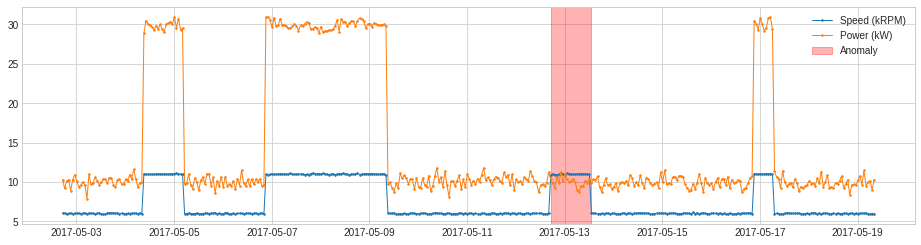

In [31]:
from adtk.detector import CustomizedDetectorHD
customized_detector = CustomizedDetectorHD(detect_func=myDetectionFunc)
anomalies = customized_detector.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

## Transformer

### RollingAggregate

`RollingAggregate` rolls a sliding window along a time series and aggregates using a selected operation. Common examples including moving average, rolling standard deviation, etc.

In the following example, we track the rolling count of valid values along a time series, which may help raise alarm when missing values occur frequently.

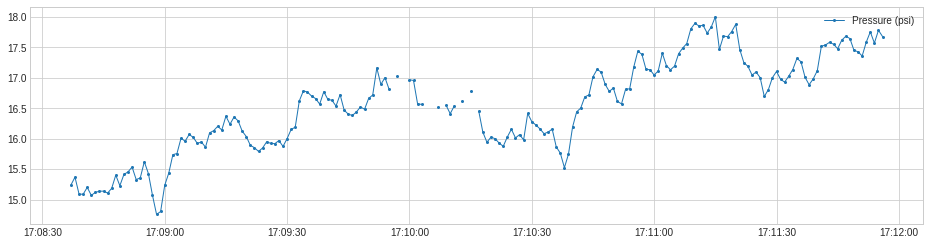

In [32]:
s = pd.read_csv('./data/pressure.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)
plot(s, ts_linewidth=1, ts_markersize=4);

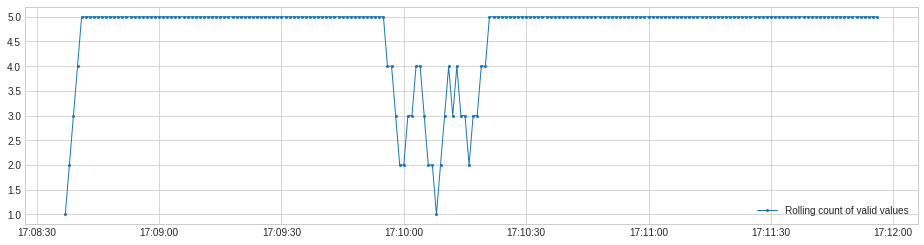

In [33]:
from adtk.transformer import RollingAggregate
s_transformed = RollingAggregate(agg='count', window=5).transform(s)
plot(s_transformed.rename("Rolling count of valid values"), ts_linewidth=1, ts_markersize=4);

### DoubleRollingAggregate

`DoubleRollingAggregate` rolls two sliding windows side-by-side along a time series, aggregates using a selected operation, and tracks difference of the aggregated metrics between the two windows. This may help tracking changes of statistical behavior in a time series.

In the following example, we track the change of statistical distribution of series values.

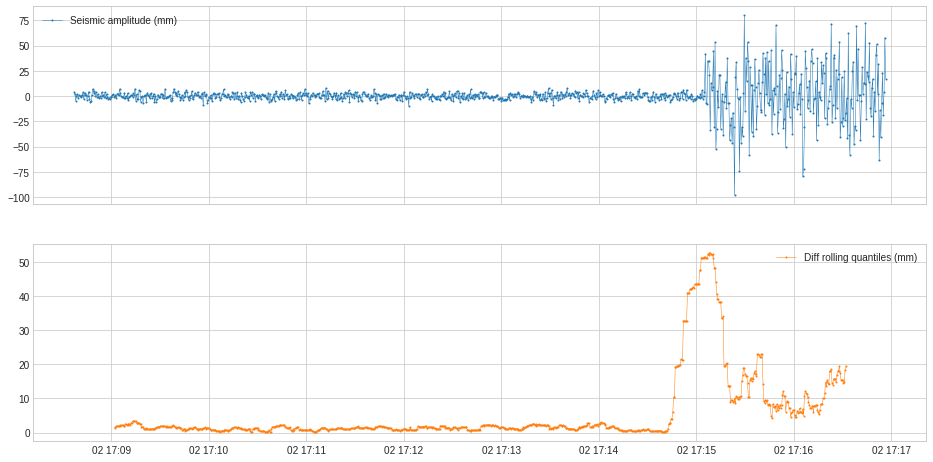

In [34]:
s = pd.read_csv('./data/seismic.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="quantile", 
    agg_params={"q": [0.1, 0.5, 0.9]}, 
    window=50,
    diff="l2").transform(s).rename("Diff rolling quantiles (mm)")

plot(pd.concat([s, s_transformed], axis=1));

In the following example, we track the shift of value level.

In [35]:
s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

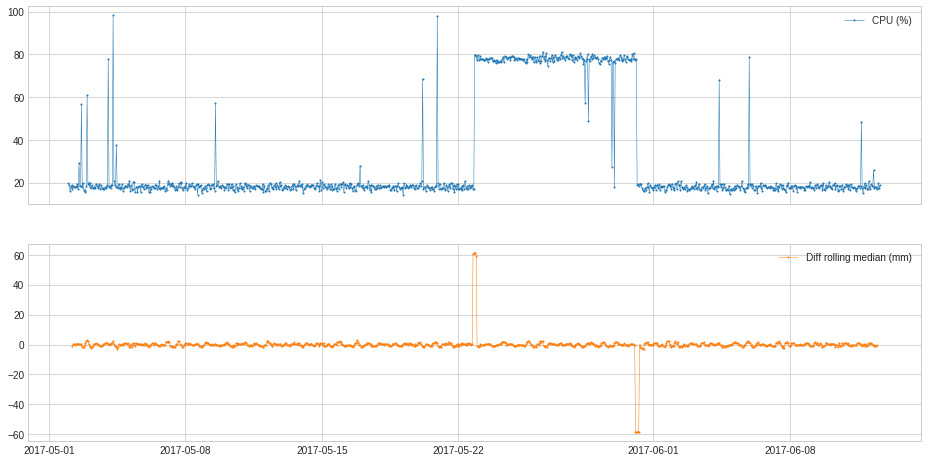

In [36]:
from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="median", 
    window=5,
    diff="diff").transform(s).rename("Diff rolling median (mm)")

plot(pd.concat([s, s_transformed], axis=1));

In the following example, we track the anomalous changes of price by adjusting the window parameter.

In [37]:
s = pd.read_csv('./data/price_short.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

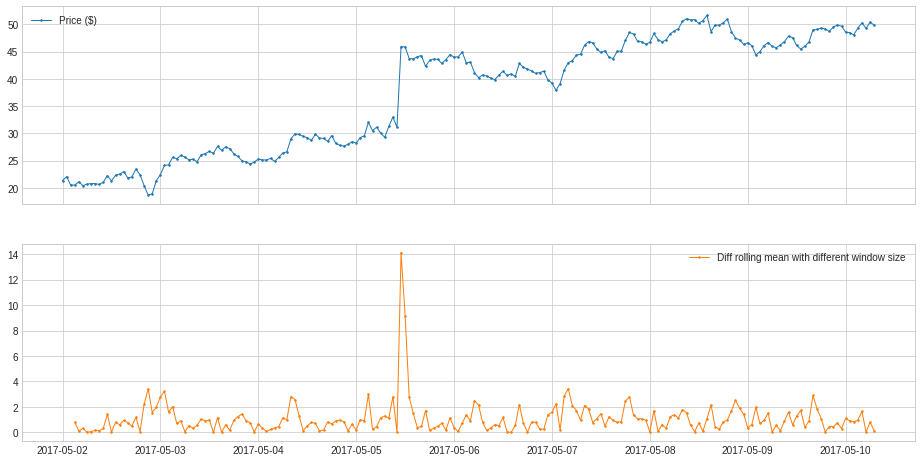

In [38]:
from adtk.transformer import DoubleRollingAggregate
s_transformed = DoubleRollingAggregate(
    agg="mean", 
    window=(3,1), #The tuple specifies the left window to be 3, and right window to be 1
    diff="l1").transform(s).rename("Diff rolling mean with different window size")

plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=3);

### ClassicSeasonalDecomposition

`ClassicSeasonalDecomposition` decomposes a series into trend part (optional), seasonal part and residual part. The residual part may help identifying anomalous deviation from seasonal pattern.

In the following example, we calculate the deviation from usual traffic pattern along the series, which may help identify unusual traffic.

In [39]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

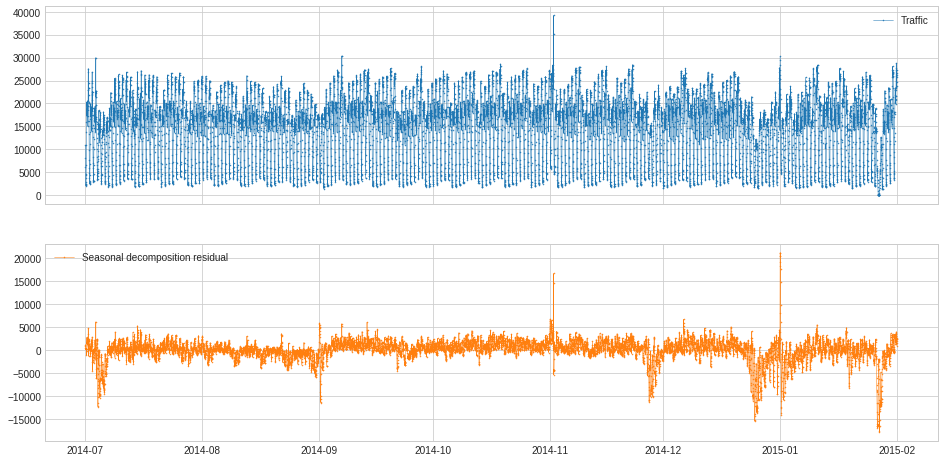

In [40]:
from adtk.transformer import ClassicSeasonalDecomposition
s_transformed = ClassicSeasonalDecomposition().fit_transform(s).rename("Seasonal decomposition residual")
plot(pd.concat([s, s_transformed], axis=1), ts_markersize=1);

`ClassicSeasonalDecomposition` without extracting trend could not handle cases where long-term trend is mixed with seasonal pattern as well as noise. In those cases, option `trend` should be turned on.

In the following example, `ClassicSeasonalDecomposition` fails to decompose residual series and long-term trend from a synthetic series without `trend` option turned on.

In [41]:
s = pd.read_csv('./data/seasonal+trend.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

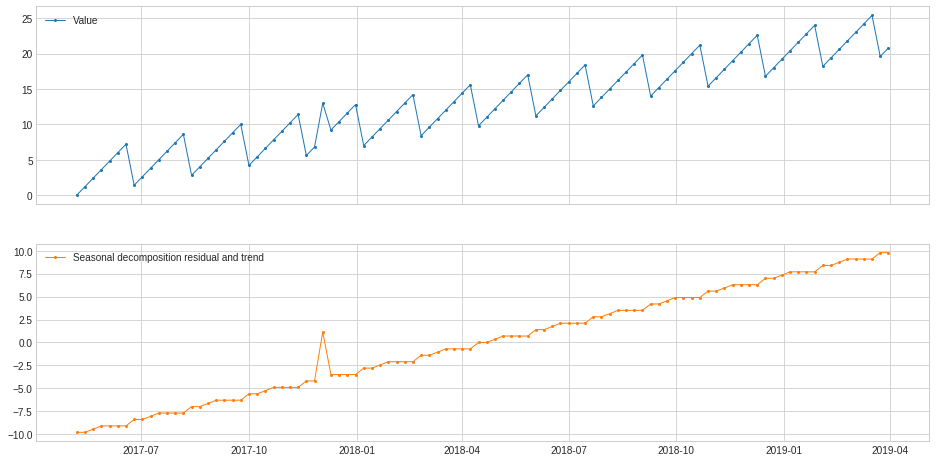

In [42]:
s_transformed = ClassicSeasonalDecomposition(freq=7).fit_transform(s).rename("Seasonal decomposition residual and trend")
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=4);

We turn on the `trend` option of the model and re-apply to the same example as above, where residual is separated from trend.

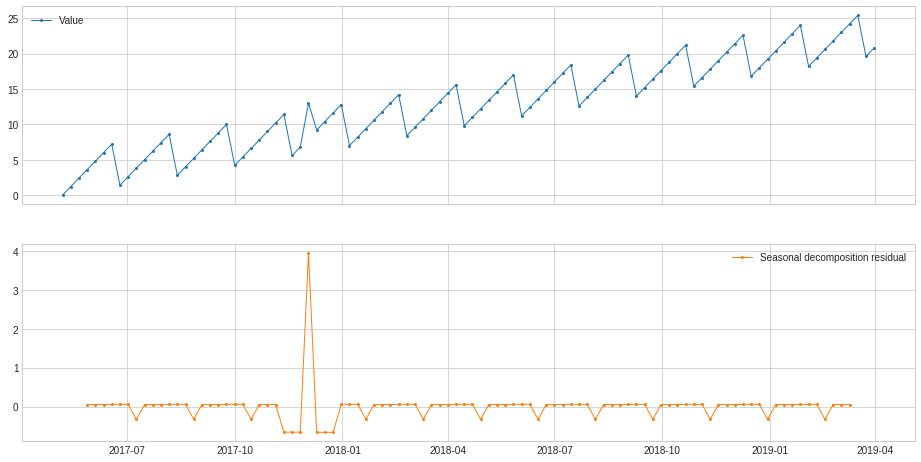

In [43]:
s_transformed = ClassicSeasonalDecomposition(freq=7, trend=True).fit_transform(s).rename("Seasonal decomposition residual")
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=4);

### Retrospect

`Retrospect` returns data frame with retrospective values, i.e. a row at time t includes value at (t-k)'s where k's are specified by user. This transformer may be useful for cases where lagging effect should be taken into account. 

In the following example, we create a retrospective data frame for a synthetic series.

In [44]:
s = pd.read_csv('./data/sin.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)

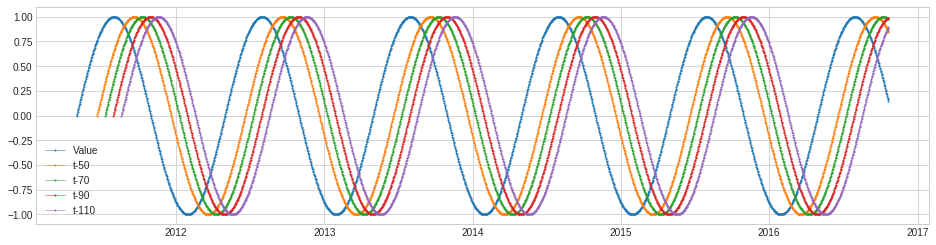

In [45]:
from adtk.transformer import Retrospect
df = Retrospect(n_steps=4, step_size=20, till=50).transform(s)
plot(pd.concat([s, df], axis=1), curve_group="all");

### RegressionResidual

`RegressionResidual` performs regression to a multivariate series and returns regressive residual. This may help identifying anomalous violation of usual relationship between series.

In the following example, we track deviation of series from usual correlation between generator speed and power.

In [46]:
df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True)
df = validate_series(df)

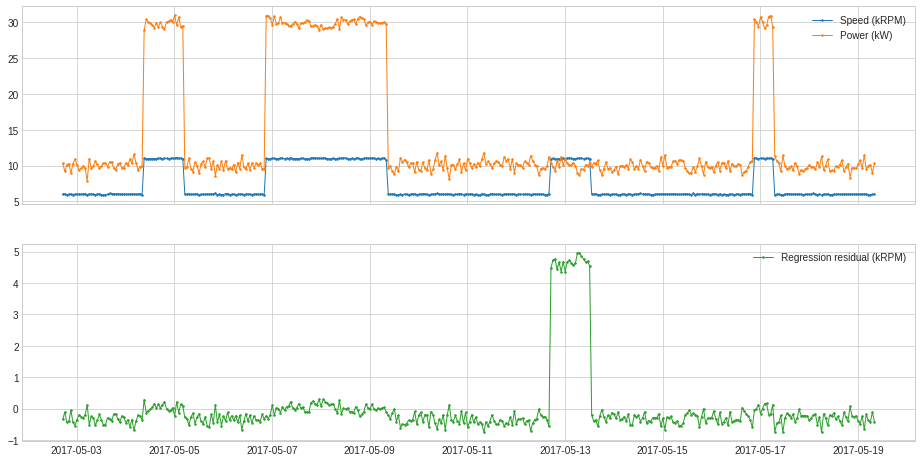

In [47]:
from adtk.transformer import RegressionResidual
s = RegressionResidual(regressor=LinearRegression(), target="Speed (kRPM)").fit_transform(df).rename("Regression residual (kRPM)")
plot(pd.concat([df, s], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), "Regression residual (kRPM)"]);

### PcaProjection

`PcaProjection` transforms a multivariate series into representation with first k principal components.

In the following example, we transform the 2-dimensional series used in the previous example into 1-dimension by only keeping its first principal coefficient.

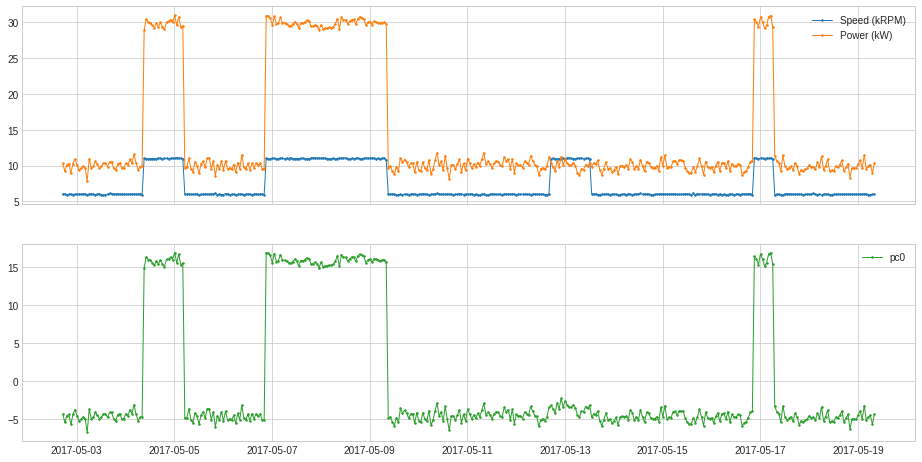

In [48]:
from adtk.transformer import PcaProjection
s = PcaProjection(k=1).fit_transform(df)
plot(pd.concat([df, s], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), "pc0"]);

### PcaReconstruction

`PcaReconstruction` projects a multivariate series onto the hyperplane spanned by its first k principal components.

In the following example, we project the 2-dimensional series used in previous example onto the line of its first principal component.

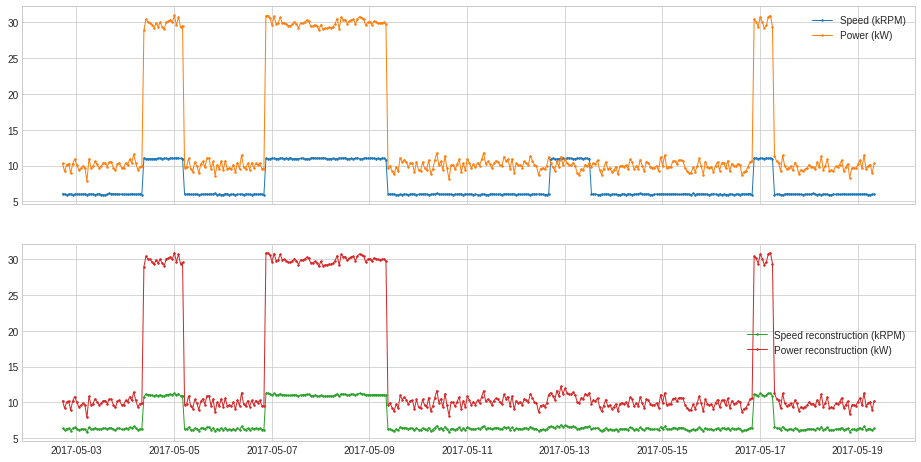

In [49]:
from adtk.transformer import PcaReconstruction
df_transformed = PcaReconstruction(k=1).fit_transform(df).rename(columns={"Speed (kRPM)": "Speed reconstruction (kRPM)", "Power (kW)": "Power reconstruction (kW)"})
plot(pd.concat([df, df_transformed], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), ("Speed reconstruction (kRPM)", "Power reconstruction (kW)")]);

### PcaReconstructionError

`PcaReconstructionError` projects a multivariate series onto the hyperplane spanned by its first k principal components and returns the error that indicates the distance between the data point and the lower-rank subspace of the first k principal components.

In the following example, we project the 2-dimensional series used in previous example onto the line of its first principal component.

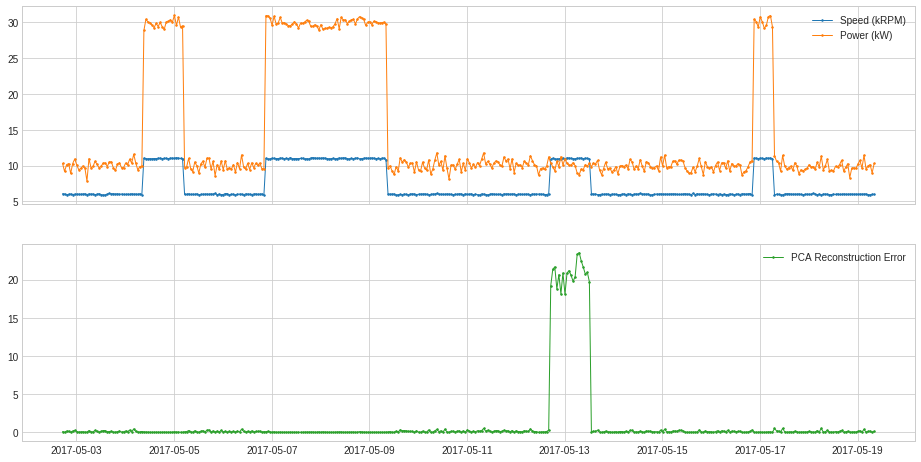

In [50]:
from adtk.transformer import PcaReconstructionError
s = PcaReconstructionError(k=1).fit_transform(df).rename("PCA Reconstruction Error")
plot(pd.concat([df, s], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), "PCA Reconstruction Error"]);

### CustomizedTransformer

Like a customized detector, a user may convert a function to a customized transformer with `CustomizedTransformer1D` or `CustomizedTransformerHD`, so that it can be used by a `Pipe` object.

In the following example, we obtained a calculated series of generated power (in kW) divided by generator speed (in kRPM).

In [51]:
df = pd.read_csv('./data/generator.csv', index_col="Time", parse_dates=True)
df = validate_series(df)

In [52]:
def myTransformationFunc(df):
    return (df["Power (kW)"] / df["Speed (kRPM)"]).rename("Power/Speed (kW/kRPM)")

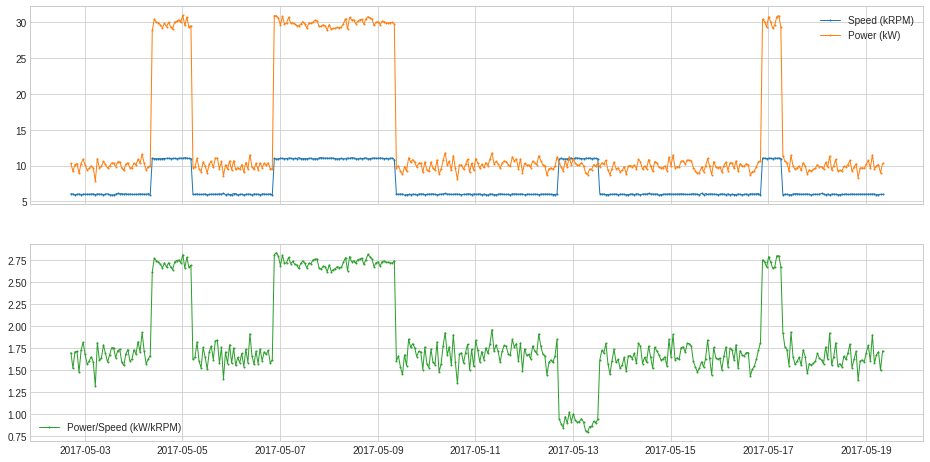

In [53]:
from adtk.transformer import CustomizedTransformerHD
customized_transformer = CustomizedTransformerHD(transform_func=myTransformationFunc)
s = customized_transformer.transform(df)
plot(pd.concat([df, s], axis=1), ts_linewidth=1, curve_group=[("Speed (kRPM)", "Power (kW)"), "Power/Speed (kW/kRPM)"]);

## Aggregator

### OrAggregator

`OrAggregator` identifies a time point as anomalous as long as it is included in one of the input anomaly lists.

It could be applied to merge anomalies in the format of binary series.

In [54]:
import numpy as np
anomaly = pd.DataFrame(
    np.array(
        [[False, True, True, False, False], 
         [False, False, True, True, False]]).T,
    columns=["overcurrent", "overheating"],
    index=pd.date_range(start="2019-12-7 14:00:00", periods=5, freq="min"))
anomaly

overcurrent  overheating
2019-12-07 14:00:00        False        False
2019-12-07 14:01:00         True        False
2019-12-07 14:02:00         True         True
2019-12-07 14:03:00        False         True
2019-12-07 14:04:00        False        False

In [55]:
from adtk.aggregator import OrAggregator
OrAggregator().aggregate(anomaly)

2019-12-07 14:00:00    False
2019-12-07 14:01:00     True
2019-12-07 14:02:00     True
2019-12-07 14:03:00     True
2019-12-07 14:04:00    False
Freq: T, dtype: bool

It could also be applied to merge anomalies in the format of event list.

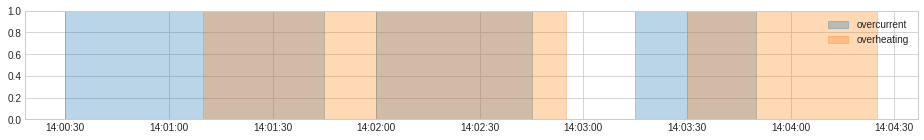

In [56]:
overcurrent = [
    (pd.Timestamp("2019-12-7 14:00:30"), pd.Timestamp("2019-12-7 14:01:45")),
    (pd.Timestamp("2019-12-7 14:02:00"), pd.Timestamp("2019-12-7 14:02:45")),
    (pd.Timestamp("2019-12-7 14:03:15"), pd.Timestamp("2019-12-7 14:03:50")),
]
overheating = [
    (pd.Timestamp("2019-12-7 14:01:10"), pd.Timestamp("2019-12-7 14:02:55")),
    (pd.Timestamp("2019-12-7 14:03:30"), pd.Timestamp("2019-12-7 14:04:25")),
]
anomaly = {"overcurrent": overcurrent, "overheating": overheating}
plot(anomaly=anomaly, figsize=(16, 2));

[(Timestamp('2019-12-07 14:00:30'), Timestamp('2019-12-07 14:02:55')),
 (Timestamp('2019-12-07 14:03:15'), Timestamp('2019-12-07 14:04:25'))]

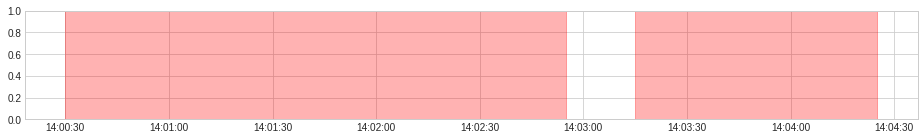

In [57]:
overcurrent_or_overheating = OrAggregator().aggregate(anomaly)
display(overcurrent_or_overheating)
plot(anomaly=overcurrent_or_overheating, anomaly_color="red", legend=False, figsize=(16, 2));

### AndAggregator

`AndAggregator`  identifies a time point as anomalous only if it is included in all the input anomaly lists.

It could be applied to merge anomalies in the format of binary series.

In [58]:
import numpy as np
anomaly = pd.DataFrame(
    np.array(
        [[False, True, True, False, False], 
         [False, False, True, True, False]]).T,
    columns=["overcurrent", "overheating"],
    index=pd.date_range(start="2019-12-7 14:00:00", periods=5, freq="min"))
anomaly

overcurrent  overheating
2019-12-07 14:00:00        False        False
2019-12-07 14:01:00         True        False
2019-12-07 14:02:00         True         True
2019-12-07 14:03:00        False         True
2019-12-07 14:04:00        False        False

In [59]:
from adtk.aggregator import AndAggregator
AndAggregator().aggregate(anomaly)

2019-12-07 14:00:00    False
2019-12-07 14:01:00    False
2019-12-07 14:02:00     True
2019-12-07 14:03:00    False
2019-12-07 14:04:00    False
Freq: T, dtype: bool

It could also be applied to merge anomalies in the format of event list.

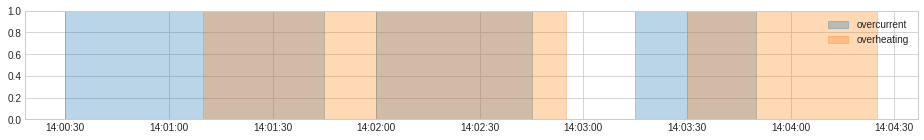

In [60]:
overcurrent = [
    (pd.Timestamp("2019-12-7 14:00:30"), pd.Timestamp("2019-12-7 14:01:45")),
    (pd.Timestamp("2019-12-7 14:02:00"), pd.Timestamp("2019-12-7 14:02:45")),
    (pd.Timestamp("2019-12-7 14:03:15"), pd.Timestamp("2019-12-7 14:03:50")),
]
overheating = [
    (pd.Timestamp("2019-12-7 14:01:10"), pd.Timestamp("2019-12-7 14:02:55")),
    (pd.Timestamp("2019-12-7 14:03:30"), pd.Timestamp("2019-12-7 14:04:25")),
]
anomaly = {"overcurrent": overcurrent, "overheating": overheating}
plot(anomaly=anomaly, figsize=(16, 2));

[(Timestamp('2019-12-07 14:01:10'), Timestamp('2019-12-07 14:01:45')),
 (Timestamp('2019-12-07 14:02:00'), Timestamp('2019-12-07 14:02:45')),
 (Timestamp('2019-12-07 14:03:30'), Timestamp('2019-12-07 14:03:50'))]

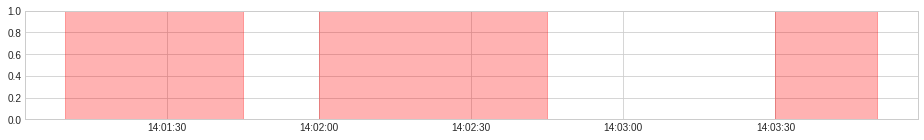

In [61]:
overcurrent_and_overheating = AndAggregator().aggregate(anomaly)
display(overcurrent_and_overheating)
plot(anomaly=overcurrent_and_overheating, anomaly_color="red", legend=False, figsize=(16, 2));

## Pipe

### Pipeline

`Pipeline` chains transformers and a detector sequentially.

In the following example, we connect a `ClassicSeasonalDecomposition` transformer with a `QuantileAD` detector, which aims at detecting anomalous deviation from regular seasonal pattern in time series. 

In [62]:
from adtk.pipe import Pipeline
steps = [
    ("deseasonal", ClassicSeasonalDecomposition()),
    ("quantile_ad", QuantileAD(high=0.995, low=0.005))
]
pipeline = Pipeline(steps)

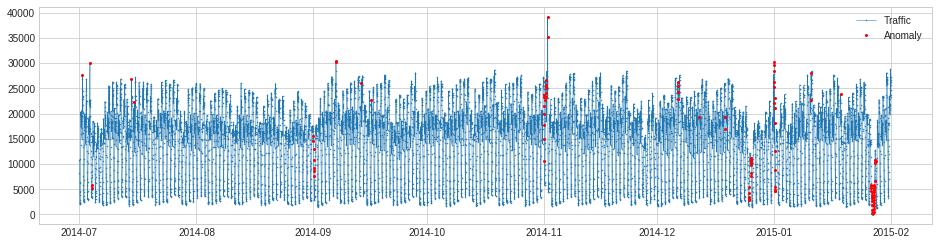

In [63]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)
anomalies = pipeline.fit_detect(s)
plot(s, anomaly=anomalies, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

A user has the option to get intermediate series and anomaly lists by setting parameter `return_intermediate` to True when calling fitting or predicting methods of a `Pipeline` object.

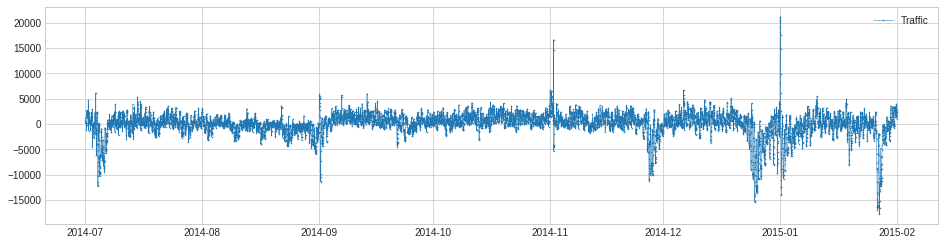

In [64]:
results = pipeline.fit_detect(s, return_intermediate=True)
plot(results["deseasonal"], ts_markersize=1);

### Pipenet

`Pipenet` is a generalization of `Pipeline` to non-sequential combination of model components. Some detectors in detector module are internally implemented by `Pipenet`.

For example, a single-side level shift detector (`LevelShiftAD` with parameter `side` as "positive" or "negative") is implemented as the following `Pipenet`. A `DoubleRollingAggregate` transformer with parameter `diff` as "l1" is connected to a `InterQuartileRangeAD` detector to detect level shift on both sides, while another `DoubleRollingAggregate` transformer with parameter `diff` as "diff" is connected to a `ThresholdAD` detector with parameter `upper_thresh` as 0 to detect positive increase level change. Positive level shifts is then obtained with an `AndAggregator` by selecting level shifts that are positive.

In [65]:
from adtk.pipe import Pipenet
steps = {
    "abs_level_change": {
        "model": DoubleRollingAggregate(
            agg="median",
            window=10,
            center=True,
            diff="l1"
        ),
        "input": "original"
    },
    "level_shift": {
        "model": InterQuartileRangeAD(c=3.0),
        "input": "abs_level_change"
    },
    "level_change": {
        "model": DoubleRollingAggregate(
            agg="median",
            window=10,
            center=True,
            diff="diff"
        ),
        "input": "original",
    },
    "positive_level_change": {
        "model": ThresholdAD(high=0),
        "input": "level_change"
    },
    "positive_level_shift": {
        "model": AndAggregator(),
        "input": ["level_shift", "positive_level_change"]
    }
}
pipenet = Pipenet(steps)

The flowchart of a `Pipenet` object can be visualized by method `plot_flowchart`.

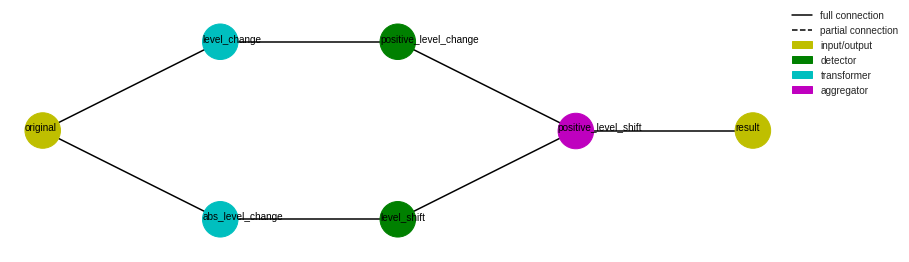

In [66]:
pipenet.plot_flowchart()

Method `summary` and `get_params` can be applied to get information of the pipenet object.

In [67]:
pipenet.summary()

name                   model                   input                                     subset
---------------------  ----------------------  ----------------------------------------  --------
abs_level_change       DoubleRollingAggregate  original                                  all
level_change           DoubleRollingAggregate  original                                  all
level_shift            InterQuartileRangeAD    abs_level_change                          all
positive_level_change  ThresholdAD             level_change                              all
positive_level_shift   AndAggregator           ['level_shift', 'positive_level_change']  all


In [68]:
pipenet.get_params()

{'abs_level_change': {'agg': 'median',
  'agg_params': None,
  'window': 10,
  'center': True,
  'min_periods': None,
  'diff': 'l1'},
 'level_shift': {'c': 3.0},
 'level_change': {'agg': 'median',
  'agg_params': None,
  'window': 10,
  'center': True,
  'min_periods': None,
  'diff': 'diff'},
 'positive_level_change': {'low': None, 'high': 0},
 'positive_level_shift': {}}

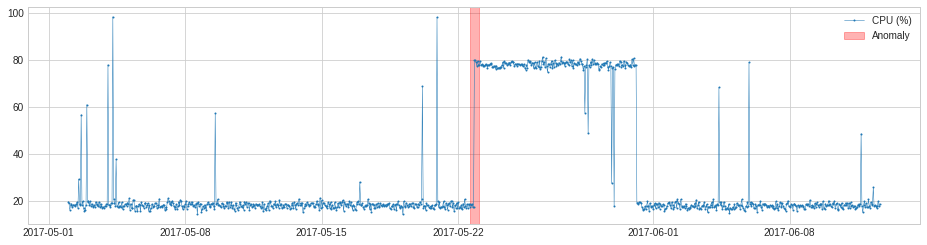

In [69]:
s = pd.read_csv('./data/cpu.csv', index_col="Time", parse_dates=True, squeeze=True)
s = validate_series(s)
anomalies = pipenet.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

Similar to `Pipeline`, a user has the option to get intermediate series and anomaly lists by setting parameter `return_intermediate` to True when calling fitting or predicting methods of a `Pipenet` object.

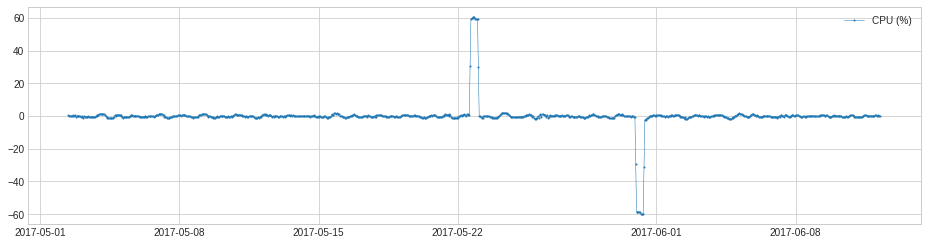

In [70]:
results = pipenet.fit_detect(s, return_intermediate=True)
plot(results["level_change"]);

## Metrics

Module `metrics` contains four types of scoring function that measure the quality of a detection results against true anomalies.

All scoring functions support two modes:
1. If inputs are in the form of binary labels, every positive time point is considered as an independent anomalous event. This is equivalent to the definition of scoring functions for time-independent binary classification.

2. If inputs are in the form of event lists, every anomaly time segment is considered as an event. The scoring function calculation will be based on the length of segment that appears in both detected list and true list.

For example, `recall`, a.k.a. sensitivity, hit rate, or true positive rate (TPR), is the percentage of true anomalies that are detected successfully. In the following example, there are 13 data points that are known anomalies. In the detection results, 9 out of 13 are detected successfully. Therefore, the recall score is equal to 9/13.

In [71]:
s_constant = pd.Series(0, pd.date_range(start='2017-1-1', periods=24, freq="1d"), name="Time Series")

label_true = pd.Series(
    [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
    pd.date_range(start='2017-1-1', periods=24, freq="1d"),
)
label_pred = pd.Series(
    [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
    pd.date_range(start='2017-1-1', periods=24, freq="1d"),
)

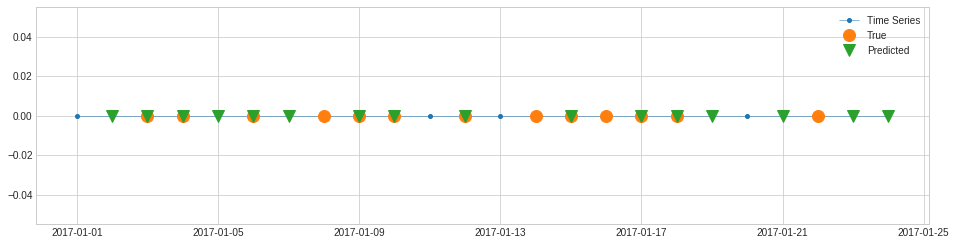

In [72]:
plot(s_constant, ts_markersize=8, 
     anomaly={"True": label_true, "Predicted": label_pred},
     anomaly_tag="marker",
     anomaly_markersize=12,
     anomaly_marker={"True": "o", "Predicted": "v"});

In [73]:
from adtk.metrics import recall
recall(label_true, label_pred)

0.6923076923076923

In the following example, there are 6 anomalous events (including 3 instantaneous events). By default, an event is considered successfully detected if no less than 50% of the segment is covered in the detection result. In this example, the first 4 events are detected according to this setting, and the last 2 events are not detected. Therefore, the recall score is equal to 4/6.

In [74]:
list_true = [
    (pd.Timestamp("2017-01-03 00:00:00"), pd.Timestamp("2017-01-03 23:59:59.999999999")),
    pd.Timestamp("2017-01-06 00:00:00"),
    (pd.Timestamp("2017-01-08 00:00:00"), pd.Timestamp("2017-01-09 23:59:59.999999999")),
    pd.Timestamp("2017-01-12 00:00:00"),
    (pd.Timestamp("2017-01-14 00:00:00"), pd.Timestamp("2017-01-17 23:59:59.999999999")),
    pd.Timestamp("2017-01-22 00:00:00"),
]
list_pred = [
    (pd.Timestamp("2017-01-02 00:00:00"), pd.Timestamp("2017-01-06 23:59:59.999999999")),
    (pd.Timestamp("2017-01-09 00:00:00"), pd.Timestamp("2017-01-09 23:59:59.999999999")),
    pd.Timestamp("2017-01-12 00:00:00"),
    pd.Timestamp("2017-01-15 00:00:00"),
    (pd.Timestamp("2017-01-17 00:00:00"), pd.Timestamp("2017-01-18 23:59:59.999999999")),
    pd.Timestamp("2017-01-21 00:00:00"),
    (pd.Timestamp("2017-01-23 00:00:00"), pd.Timestamp("2017-01-23 23:59:59.999999999")),
]

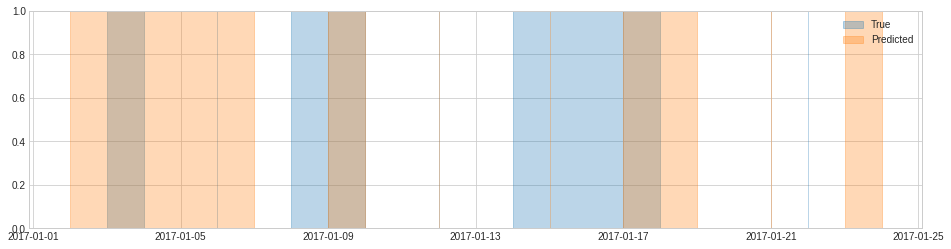

In [75]:
plot(anomaly={"True": list_true, "Predicted": list_pred},);

In [76]:
recall(list_true, list_pred)

0.6666666666666666

If we restrict the criteria of successful detection such that an event must have more than 90% time segment covered to be considered as detected successfully, the third event is then not a successful detection because only half of its segment are detected, and therefore recall score is equal to 3/6.

In [77]:
recall(list_true, list_pred, thresh=0.9)

0.5

Scoring function `precision` is similar to `recall`, except it calculates the percentage of predicted anomalies that are true anomalies. It is also called positive predictive value (PPV) in some context. 

If a detector is too tolerant, `recall` score will be high, while `precision` will be low. If a detector is too strict, `recall` score will be low, while `recall` will be high.

`f1_score` is a compromise between these two, where the harmonic means of recall and precision is returned.

Intersect over union (IoU) score `iou` calculated the length ratio between time segments that are identified as anomalous in both lists and those identified by at least one of the two lists. In the previous example, the union between true anomalous segments and detected segments are 13 days, while the intersect is 3 days. Therefore the IoU score is 3/13.

In [78]:
from adtk.metrics import iou
iou(list_true, list_pred)

0.2307692307692289

## Data Processing

Module `data` provides some functions for common time series processing operations.

### Validate time series

Function `validate_series` checks some common critical issues that may cause problems if anomaly detection is performed to time series without fixing them. The function will automatically fix some of them, while it will raise errors when detect others.

Issues will be checked and automatically fixed include:

- Time index is not monotonically increasing;
- Time index contains duplicated time stamps (fix by keeping first values);
- (optional) Time index attribute `freq` is missed;
- (optional) Time series include categorical (non-binary) label columns
  (to fix by converting categorical labels into binary indicators).

Issues will be checked and raise error include:

- Wrong type of time series object (must be pandas Series or DataFrame);
- Wrong type of time index object (must be pandas DatetimeIndex).

In the following example, we validate a series with duplicated time point, unsorted index, and missed frequency.

In [79]:
df = pd.read_csv('./data/invalid_series.csv', index_col="time", parse_dates=True)
df

value category
time                      
2017-01-02    2.0     even
2017-01-01    1.0      odd
2017-01-03    3.0      odd
2017-01-03    3.5      odd
2017-01-06    6.0     even
2017-01-04    4.0     even
2017-01-05    5.0      odd
2017-01-07    7.0      odd
2017-01-04    4.5     even
2017-01-08    8.0     even

In [80]:
from adtk.data import validate_series
validate_series(df)

value category
time                      
2017-01-01    1.0      odd
2017-01-02    2.0     even
2017-01-03    3.0      odd
2017-01-04    4.0     even
2017-01-05    5.0      odd
2017-01-06    6.0     even
2017-01-07    7.0      odd
2017-01-08    8.0     even

Optionally, the function may automatically switch categorical series into binary series.

In [81]:
from adtk.data import validate_series
validate_series(df, check_categorical=True)

value  category_even  category_odd
time                                          
2017-01-01    1.0              0             1
2017-01-02    2.0              1             0
2017-01-03    3.0              0             1
2017-01-04    4.0              1             0
2017-01-05    5.0              0             1
2017-01-06    6.0              1             0
2017-01-07    7.0              0             1
2017-01-08    8.0              1             0

### Validate event list

Function `validate_events` checks the validity of an event list (a list of time windows). Common issues includes invalid time window, overlapped or consecutive time windows, unsorted events, etc.

In [82]:
event_list = [
    (pd.Timestamp('2017-1-2 23:59:59.999999999'), pd.Timestamp('2017-1-1 00:00:00.000000000')),
    (pd.Timestamp('2017-1-2 00:00:00.000000000'), pd.Timestamp('2017-1-3 23:59:59.999999999')),
    (pd.Timestamp('2017-1-8 00:00:00.000000000'), pd.Timestamp('2017-1-9 23:59:59.999999999')),
    pd.Timestamp('2017-1-5 00:00:00.000000000'),
    (pd.Timestamp('2017-1-9 00:00:00.000000000'), pd.Timestamp('2017-1-10 23:59:59.999999999')),
    (pd.Timestamp('2017-1-4 00:00:00.000000000'), pd.Timestamp('2017-1-5 23:59:59.999999999')),
    pd.Timestamp('2017-1-7 00:00:00.000000000')
]
event_list

[(Timestamp('2017-01-02 23:59:59.999999999'),
  Timestamp('2017-01-01 00:00:00')),
 (Timestamp('2017-01-02 00:00:00'),
  Timestamp('2017-01-03 23:59:59.999999999')),
 (Timestamp('2017-01-08 00:00:00'),
  Timestamp('2017-01-09 23:59:59.999999999')),
 Timestamp('2017-01-05 00:00:00'),
 (Timestamp('2017-01-09 00:00:00'),
  Timestamp('2017-01-10 23:59:59.999999999')),
 (Timestamp('2017-01-04 00:00:00'),
  Timestamp('2017-01-05 23:59:59.999999999')),
 Timestamp('2017-01-07 00:00:00')]

In [83]:
from adtk.data import validate_events
validated_event_list = validate_events(event_list)
validated_event_list

[(Timestamp('2017-01-02 00:00:00'),
  Timestamp('2017-01-05 23:59:59.999999999')),
 Timestamp('2017-01-07 00:00:00'),
 (Timestamp('2017-01-08 00:00:00'),
  Timestamp('2017-01-10 23:59:59.999999999'))]

### Convert a binary series into an event list

Function `to_events` converts a binary series into an event list.

In [84]:
s = pd.Series([True, False, False, True, True, True, False, False, True, False],
              index=pd.date_range(start='2017-1-1', periods=10, freq='D'))

In [85]:
from adtk.data import to_events
to_events(s)

[(Timestamp('2017-01-01 00:00:00', freq='D'),
  Timestamp('2017-01-01 23:59:59.999999999', freq='D')),
 (Timestamp('2017-01-04 00:00:00', freq='D'),
  Timestamp('2017-01-06 23:59:59.999999999', freq='D')),
 (Timestamp('2017-01-09 00:00:00', freq='D'),
  Timestamp('2017-01-09 23:59:59.999999999', freq='D'))]

For a series with regular frequency, every time item in the series is assumed to represent a period instead of an instantaneous time point by default. A user may turn this option off by setting `freq_as_period` to False.

In [86]:
to_events(s, freq_as_period=False)

[Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-01-04 00:00:00'),
 Timestamp('2017-01-05 00:00:00'),
 Timestamp('2017-01-06 00:00:00'),
 Timestamp('2017-01-09 00:00:00')]

When time points are treated as instantaneous instants, the function will not merge "consecutive" points by default, because "consecutive" is a concept on continuous time line. By setting `merge_consecutive` to True, a user may force the function to return "consecutive" time window where positive time points next to each other in the time index are merged into a same event. A user should be careful of the meaning of such time windows.

In [87]:
to_events(s, freq_as_period=False, merge_consecutive=True)

[Timestamp('2017-01-01 00:00:00', freq='D'),
 (Timestamp('2017-01-04 00:00:00', freq='D'),
  Timestamp('2017-01-06 00:00:00', freq='D')),
 Timestamp('2017-01-09 00:00:00', freq='D')]

### Convert an event list into a binary series

Function `to_labels` converts an event lists into a binary series following a given time index.

Similarly to `to_events`, argument `freq_as_period` controls whether an element in a time index with regular frequency represent a period or a time instant. If a period, the period is marked positive as long as an event overlaps with it. Otherwise, a time instant is marked as positive if an event covered it.

In [88]:
time_index = pd.date_range(start='2017-1-1', periods=5, freq='D')
time_index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05'],
              dtype='datetime64[ns]', freq='D')

In [89]:
event_list = [(pd.Timestamp('2017-1-2 18:30:00'), pd.Timestamp('2017-1-3 02:00:00')),
              (pd.Timestamp('2017-1-4 20:00:00'), pd.Timestamp('2017-1-5 09:30:00'))]

In [90]:
from adtk.data import to_labels
to_labels(event_list, time_index, freq_as_period=True)

2017-01-01    False
2017-01-02     True
2017-01-03     True
2017-01-04     True
2017-01-05     True
Freq: D, dtype: bool

In [91]:
to_labels(event_list, time_index, freq_as_period=False)

2017-01-01    False
2017-01-02    False
2017-01-03     True
2017-01-04    False
2017-01-05     True
Freq: D, dtype: bool

### Expand during of events

When calculating the quality of a detection result, sometimes slight offset is acceptable. Function `expand_events` expands the duration of events in a list by a given factor, such that scoring is more tolerant.

In the following example, we have a detection result with 2 ~ 3 minutes offset from the true anomaly list. If we accept 5 minutes offset forward and backward, the score of the result is more meaningful.

In [92]:
true_anomaly_list = [
    pd.Timestamp('2017-1-2 18:00:00'),
    pd.Timestamp('2017-1-4 20:00:00')]

In [93]:
detected_anomaly_list = [
    pd.Timestamp('2017-1-2 18:02:00'),
    pd.Timestamp('2017-1-4 19:57:00')]

In [94]:
from adtk.metrics import precision
precision(true_anomaly_list, detected_anomaly_list)

0.0

In [95]:
from adtk.data import expand_events
expanded_true_anomaly_list = expand_events(
    true_anomaly_list, left_expand='5min', right_expand='5min')
expanded_true_anomaly_list

[(Timestamp('2017-01-02 17:55:00'), Timestamp('2017-01-02 18:05:00')),
 (Timestamp('2017-01-04 19:55:00'), Timestamp('2017-01-04 20:05:00'))]

In [96]:
precision(expanded_true_anomaly_list, detected_anomaly_list)

1.0

### Resample a time series with new spacing

Function `resample` samples time series with given new spacing. Resampled values are determined by time-weighted linear interpolation.

In following example, we resample the given time series with spacing of 1 day.

In [97]:
s = pd.Series([1, 2.5, 3, 4.25, 6, 9],
              index=pd.DatetimeIndex(['2017-1-1 00:00:00', '2017-1-2 12:00:00', '2017-1-3 00:00:00',
                                      '2017-1-4 06:00:00', '2017-1-6 00:00:00', '2017-1-9 00:00:00']))

In [98]:
from adtk.data import resample
resample(s, dT="1 day")

2017-01-01    1.0
2017-01-02    2.0
2017-01-03    3.0
2017-01-04    4.0
2017-01-05    5.0
2017-01-06    6.0
2017-01-07    7.0
2017-01-08    8.0
2017-01-09    9.0
Freq: D, dtype: float64

If no spacing is specified, the greatest common divider of original time steps will be used, which makes the refinement of time line a minimal refinement subject to keeping all original time points still included in the resampled time series. Please note that this may dramatically increase the size of time series and memory usage.

For the previous example, such a refinement yields constant spacing of 6 hours. All original time points are kept in the refined series.

In [99]:
resample(s)

2017-01-01 00:00:00    1.00
2017-01-01 06:00:00    1.25
2017-01-01 12:00:00    1.50
2017-01-01 18:00:00    1.75
2017-01-02 00:00:00    2.00
2017-01-02 06:00:00    2.25
2017-01-02 12:00:00    2.50
2017-01-02 18:00:00    2.75
2017-01-03 00:00:00    3.00
2017-01-03 06:00:00    3.25
2017-01-03 12:00:00    3.50
2017-01-03 18:00:00    3.75
2017-01-04 00:00:00    4.00
2017-01-04 06:00:00    4.25
2017-01-04 12:00:00    4.50
2017-01-04 18:00:00    4.75
2017-01-05 00:00:00    5.00
2017-01-05 06:00:00    5.25
2017-01-05 12:00:00    5.50
2017-01-05 18:00:00    5.75
2017-01-06 00:00:00    6.00
2017-01-06 06:00:00    6.25
2017-01-06 12:00:00    6.50
2017-01-06 18:00:00    6.75
2017-01-07 00:00:00    7.00
2017-01-07 06:00:00    7.25
2017-01-07 12:00:00    7.50
2017-01-07 18:00:00    7.75
2017-01-08 00:00:00    8.00
2017-01-08 06:00:00    8.25
2017-01-08 12:00:00    8.50
2017-01-08 18:00:00    8.75
2017-01-09 00:00:00    9.00
Freq: 6H, dtype: float64

### Split a time series into training and testing segments

When building a time series anomaly detection model, splitting a historical series into training and testing segments is a common operation needed.

Function `split_train_test` provides four modes of splitting. A user may choose from it according to the specific case.

1. Divide time series into n_splits folds of equal length, split each fold into training and testing based on train_ratio.

2. Create n_splits folds, where each fold starts at t_0 and ends at t_(n/n_splits), where n goes from 0 to n_splits and the first train_ratio of the fold is for training.

3. Create n_splits folds, where each fold starts at t_0. Each fold has len(ts)/(1 + n_splits) test points at the end. Each fold is n * len(ts)/(1 + n_splits) long, where n ranges from 1 to n_splits.

4. Create n_splits folds, where each fold starts at t_0. Each fold has n * len(ts)/(1 + n_splits) training points at the beginning of the time series, where n ranges from 1 to n_splits and the remaining points are testing points.

In [100]:
s = pd.read_csv('./data/seasonal.csv', index_col="Time", parse_dates=True, squeeze=True)

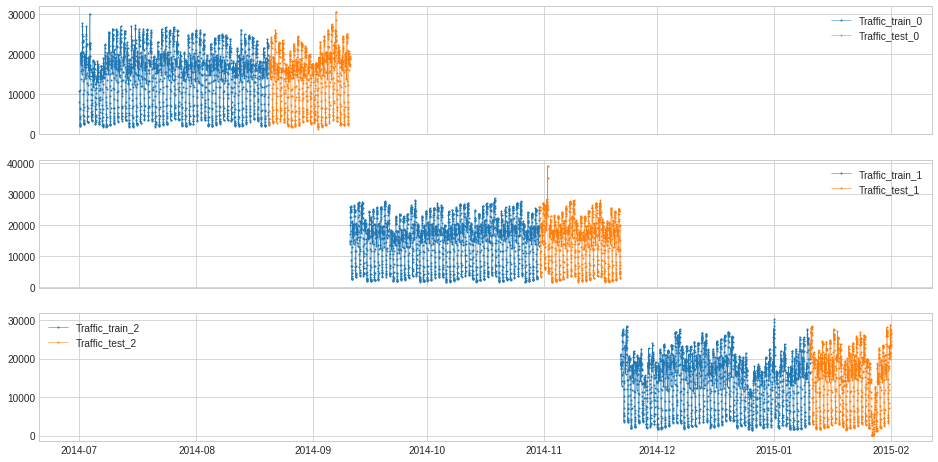

In [101]:
from adtk.data import split_train_test
s_train, s_test = split_train_test(s, mode=1, n_splits=3)
plot(pd.concat(s_train+s_test, axis=1), 
     curve_group=[("Traffic_train_{}".format(i), "Traffic_test_{}".format(i)) for i in range(3)],
     ts_color={**{"Traffic_train_{}".format(i): "tab:blue" for i in range(3)}, **{"Traffic_test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

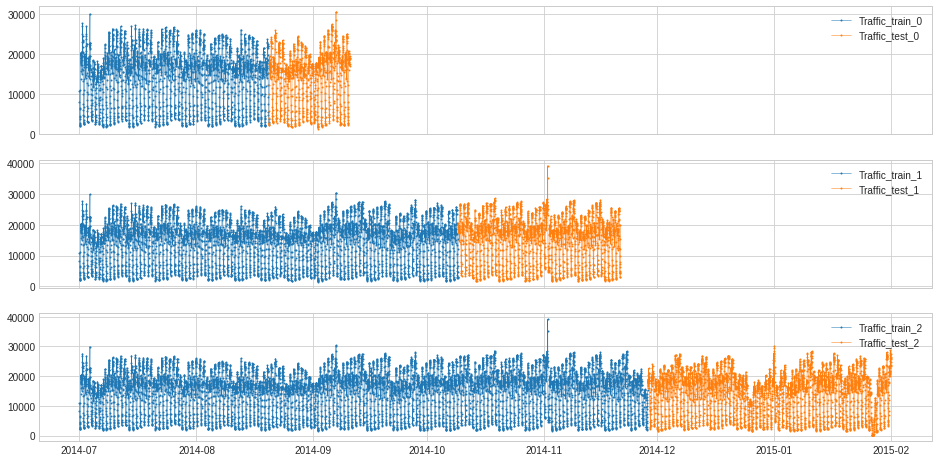

In [102]:
s_train, s_test = split_train_test(s, mode=2, n_splits=3)
plot(pd.concat(s_train+s_test, axis=1), 
     curve_group=[("Traffic_train_{}".format(i), "Traffic_test_{}".format(i)) for i in range(3)],
     ts_color={**{"Traffic_train_{}".format(i): "tab:blue" for i in range(3)}, **{"Traffic_test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

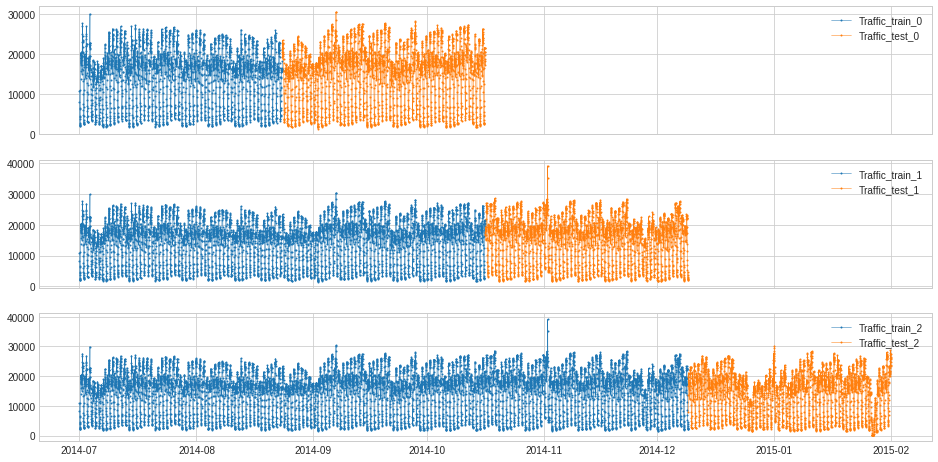

In [103]:
s_train, s_test = split_train_test(s, mode=3, n_splits=3)
plot(pd.concat(s_train+s_test, axis=1), 
     curve_group=[("Traffic_train_{}".format(i), "Traffic_test_{}".format(i)) for i in range(3)],
     ts_color={**{"Traffic_train_{}".format(i): "tab:blue" for i in range(3)}, **{"Traffic_test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

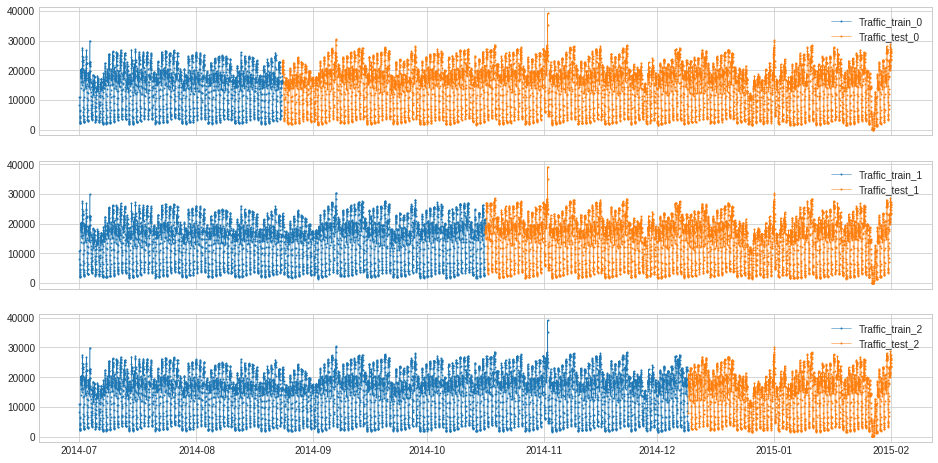

In [104]:
s_train, s_test = split_train_test(s, mode=4, n_splits=3)
plot(pd.concat(s_train+s_test, axis=1), 
     curve_group=[("Traffic_train_{}".format(i), "Traffic_test_{}".format(i)) for i in range(3)],
     ts_color={**{"Traffic_train_{}".format(i): "tab:blue" for i in range(3)}, **{"Traffic_test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));